# Breakdown of Assesment
 ## Data Sources
1. Outpatient Charges (SQLite tables for 2011-2013): These tables contain data such as the provider’s location, services billed, average charges, and payments.
2. Inpatient Charges (JSON files for 2011-2013): These files include data on discharges, average covered charges, total payments, and Medicare payments.
3. Provider Information (CSV file): Contains general information about healthcare providers like names, addresses, and mortality measures.
4. ICD10 API (for diagnosis codes): You need to access this API to enrich the dataset with ICD10 diagnosis codes and descriptions.

## Tasks
clean, merge, and analyze these datasets to answer specific questions:

a. Average Outpatient and Inpatient Medicare Payments

Calculate the average inpatient and outpatient Medicare payments per provider for each year (2011-2013).
The focus should be on including copayments for outpatient charges.
b. Time Series Analysis (APC Services)

Analyze how the average charge for different APC (Ambulatory Payment Classification) services has evolved over the years (2011-2013) for each provider.

c. Geographical Analysis (Emergency Services)

Identify affordable providers offering emergency services by state and analyze geographically.

d. Inpatient ICD10 Diagnosis Analysis

Analyze the top 10 prominent ICD10 diagnoses by state. You’ll likely need to pull ICD10 descriptions (Chapters and Blocks) from the API and map them to the inpatient charge data.
## Visualizations

Average Medicare Payments: Bar/column charts showing the ranking of providers.
Time Series (APC services): Line charts for trends in average charges.
Geographical Analysis: A map chart showing affordable providers by state.
ICD10 Diagnosis: Use bar/treemap to show the distribution of the top 10 diagnoses per state.

# Loading Files

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hospital_general_info.csv to hospital_general_info.csv
Saving hospital_general_info.xlsx to hospital_general_info.xlsx
Saving inpatient_2011.json to inpatient_2011.json
Saving inpatient_2012.json to inpatient_2012.json
Saving inpatient_2013.json to inpatient_2013.json
Saving outpatient_charges.db to outpatient_charges.db


# Data Importation and Enrichment

In [ ]:
import sqlite3
import pandas as pd
import json
import requests

Oupatient data

In [ ]:
# Connectting to the SQLite database
conn = sqlite3.connect('outpatient_charges.db')

# Loading each year’s data into separate DataFrames
outpatient_2011 = pd.read_sql_query("SELECT * FROM outpatient_charges_2011", conn)
outpatient_2012 = pd.read_sql_query("SELECT * FROM outpatient_charges_2012", conn)
outpatient_2013 = pd.read_sql_query("SELECT * FROM outpatient_charges_2013", conn)

print(outpatient_2011.head(1))
print(outpatient_2012.head(1))
print(outpatient_2013.head(1))

# Close the connection
conn.close()

   provider_id                     provider_name provider_street_address  \
0        30036  CHANDLER REGIONAL MEDICAL CENTER   475 SOUTH DOBSON ROAD   

  provider_city provider_state  provider_zipcode  \
0      CHANDLER             AZ             85224   

                                         apc  outpatient_services  \
0  0013 - Level II Debridement & Destruction                   31   

   average_estimated_submitted_charges  average_total_payments  
0                           327.515806               49.889032  
   provider_id                     provider_name provider_street_address  \
0        30036  CHANDLER REGIONAL MEDICAL CENTER   475 SOUTH DOBSON ROAD   

  provider_city provider_state  provider_zipcode  \
0      CHANDLER             AZ             85224   

                                         apc  outpatient_services  \
0  0013 - Level II Debridement & Destruction                   37   

   average_estimated_submitted_charges  average_total_payments  
0          

general / Provider info data

In [ ]:
general_info = pd.read_csv('hospital_general_info.csv')
print(general_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5336 entries, 0 to 5335
Data columns (total 38 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   provider_id                                            5336 non-null   object 
 1   hospital_name                                          5336 non-null   object 
 2   address                                                5336 non-null   object 
 3   city                                                   5336 non-null   object 
 4   state                                                  5336 non-null   object 
 5   zip_code                                               5336 non-null   int64  
 6   county_name                                            5336 non-null   object 
 7   phone_number                                           5336 non-null   object 
 8   hospital_type                                   

## Inpatient data

In [ ]:
#loading the impatient data
import json

# Load JSON files for each year
with open('inpatient_2011.json') as f:
    inpatient_2011 = pd.json_normalize(json.load(f))

with open('inpatient_2012.json') as f:
    inpatient_2012 = pd.json_normalize(json.load(f))

with open('inpatient_2011.json') as f:
    inpatient_2013 = pd.json_normalize(json.load(f))

# preview of the data
print(inpatient_2011.head())
print(inpatient_2012.head())
print(inpatient_2013.head())

   provider_id                 provider_name   provider_street_address  \
0     450270.0   LAKE WHITNEY MEDICAL CENTER  200 N SAN JACINTO STREET   
1     450270.0   LAKE WHITNEY MEDICAL CENTER  200 N SAN JACINTO STREET   
2     450270.0   LAKE WHITNEY MEDICAL CENTER  200 N SAN JACINTO STREET   
3     450270.0   LAKE WHITNEY MEDICAL CENTER  200 N SAN JACINTO STREET   
4     370171.0  W W HASTINGS INDIAN HOSPITAL        100 S BLISS AVENUE   

  provider_city provider_state  provider_zipcode  \
0       WHITNEY             TX           76692.0   
1       WHITNEY             TX           76692.0   
2       WHITNEY             TX           76692.0   
3       WHITNEY             TX           76692.0   
4     TAHLEQUAH             OK           74464.0   

  hospital_referral_region_description  total_discharges  \
0                            TX - Waco              15.0   
1                            TX - Waco              35.0   
2                            TX - Waco              12.0   
3 

## ICD10 - API Data

In [ ]:
import requests

TOKEN_URL = "https://icdaccessmanagement.who.int/connect/token"
API_BASE_URL = "https://id.who.int/icd/release/10/2019/"
CLIENT_ID = "#"
CLIENT_SECRET = "#"
SCOPE = "icdapi_access"

# Function to get the bearer token
def get_access_token():
    try:
        response = requests.post(
            TOKEN_URL,
            data={
                "client_id": CLIENT_ID,
                "client_secret": CLIENT_SECRET,
                "grant_type": "client_credentials",
                "scope": SCOPE,
            },
            headers={"Content-Type": "application/x-www-form-urlencoded"}
        )
        response.raise_for_status()  # Raise an error for unsuccessful requests
        return response.json()["access_token"]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching access token: {e}")
        return None

# Function to fetch data for a single ICD-10 code
def fetch_icd10_data(code, token):
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/json",
        "Accept-Language": "en",
        "API-Version": "v2",
    }
    try:
        response = requests.get(f"{API_BASE_URL}{code}", headers=headers)
        response.raise_for_status()
        return response.json()  # Return the JSON data for the ICD-10 code
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch data for {code}. Error: {e}")
        return None

# Main function to retrieve data for a list of ICD-10 codes
def retrieve_icd10_data(icd10_codes):
    token = get_access_token()
    if not token:
        print("Failed to retrieve access token.")
        return None

    icd10_data = {}
    for code in icd10_codes:
        print(f"Fetching data for ICD-10 code: {code}")
        data = fetch_icd10_data(code, token)
        if data:
            icd10_data[code] = data
        else:
            print(f"No data returned for ICD-10 code: {code}")

    return icd10_data

# List of ICD-10 codes to fetch
icd10_codes = ['G81', 'T79', 'I02', 'D18', 'P12', 'D22', 'B96', 'D31', 'D28',
       'B95', 'D29', 'R77', 'D86', 'R82', 'J03', 'L11', 'D26', 'I01',
       'J02', 'I60', 'R79', 'F50', 'I69', 'F90', 'Y07', 'I66', 'G82',
       'I63', 'J01', 'I67', 'G80', 'D19', 'P11', 'D16', 'F53', 'B97',
       'F52', 'D13', 'D17', 'R73', 'D10', 'J05', 'R74', 'A93', 'D11',
       'I65', 'R78', 'B98', 'P15', 'D36', 'F51', 'Y06', 'A96', 'L13',
       'P10', 'I62', 'R94', 'A95', 'R70', 'D20', 'F98', 'A97', 'F92',
       'D23', 'R90', 'D15', 'D21', 'D30', 'D33', 'F93', 'D81', 'F94',
       'R76', 'D25', 'D35', 'J06', 'D14', 'A92', 'I68', 'D64', 'A98',
       'D12', 'F95', 'D61', 'G83', 'D32', 'J04', 'D60', 'L10', 'D83',
       'P14', 'P13', 'D63', 'F91']

# Retrieving data for the specified codes
icd10_data = retrieve_icd10_data(icd10_codes)

# Print or process the data
if icd10_data:
    print("Successfully retrieved ICD-10 data.")
    for code, data in icd10_data.items():
        print(f"Code: {code} - Data: {data}")


Fetching data for ICD-10 code: G81
Fetching data for ICD-10 code: T79
Fetching data for ICD-10 code: I02
Fetching data for ICD-10 code: D18
Fetching data for ICD-10 code: P12
Fetching data for ICD-10 code: D22
Fetching data for ICD-10 code: B96
Fetching data for ICD-10 code: D31
Fetching data for ICD-10 code: D28
Fetching data for ICD-10 code: B95
Fetching data for ICD-10 code: D29
Fetching data for ICD-10 code: R77
Fetching data for ICD-10 code: D86
Fetching data for ICD-10 code: R82
Fetching data for ICD-10 code: J03
Fetching data for ICD-10 code: L11
Fetching data for ICD-10 code: D26
Fetching data for ICD-10 code: I01
Fetching data for ICD-10 code: J02
Fetching data for ICD-10 code: I60
Fetching data for ICD-10 code: R79
Fetching data for ICD-10 code: F50
Fetching data for ICD-10 code: I69
Fetching data for ICD-10 code: F90
Fetching data for ICD-10 code: Y07
Fetching data for ICD-10 code: I66
Fetching data for ICD-10 code: G82
Fetching data for ICD-10 code: I63
Fetching data for IC

In [ ]:
#scraping the ICD - API data
import requests

client_id = "#"
client_secret = "#"

def get_access_token(client_id, client_secret):
    url = "https://icdaccessmanagement.who.int/connect/token"
    data = {
        "client_id": client_id,
        "client_secret": client_secret,
        "scope": "icdapi_access",
        "grant_type": "client_credentials"
    }

    response = requests.post(url, data=data)
    response.raise_for_status()
    return response.json()["access_token"]

# Fetch the access token
access_token = get_access_token(client_id, client_secret)

# EDA

In [ ]:
general_info['provider_id'].dtype

dtype('O')

In [ ]:
outpatient_2011['provider_id'].dtype

dtype('int64')

In [ ]:
outpatient_2011['provider_id'].nunique()

3135

In [ ]:
inpatient_2011.icd_category.head()

,icd_category
0,G81
1,T79
2,I02
3,D18
4,P12


In [ ]:
inpatient_2011.icd_category.unique()

array(['G81', 'T79', 'I02', 'D18', 'P12', 'D22', 'B96', 'D31', 'D28',
       'B95', 'D29', 'R77', 'D86', 'R82', 'J03', 'L11', 'D26', 'I01',
       'J02', 'I60', 'R79', 'F50', 'I69', 'F90', 'Y07', 'I66', 'G82',
       'I63', 'J01', 'I67', 'G80', 'D19', 'P11', 'D16', 'F53', 'B97',
       'F52', 'D13', 'D17', 'R73', 'D10', 'J05', 'R74', 'A93', 'D11',
       'I65', 'R78', 'B98', 'P15', 'D36', 'F51', 'Y06', 'A96', 'L13',
       'P10', 'I62', 'R94', 'A95', 'R70', 'D20', 'F98', 'A97', 'F92',
       'D23', 'R90', 'D15', 'D21', 'D30', 'D33', 'F93', 'D81', 'F94',
       'R76', 'D25', 'D35', 'J06', 'D14', 'A92', 'I68', 'D64', 'A98',
       'D12', 'F95', 'D61', 'G83', 'D32', 'J04', 'D60', 'L10', 'D83',
       'P14', 'P13', 'D63', 'F91'], dtype=object)

In [ ]:
inpatient_2012.icd_category.nunique()

95

In [ ]:
inpatient_2013.icd_category.nunique()

94

In [ ]:
inpatient_2011.columns

Index(['provider_id', 'provider_name', 'provider_street_address',
       'provider_city', 'provider_state', 'provider_zipcode',
       'hospital_referral_region_description', 'total_discharges',
       'average_covered_charges', 'average_total_payments',
       'average_medicare_payments', 'icd_category'],
      dtype='object')

In [ ]:
# Converting 'provider_id' to a common data type before merging
outpatient_2011['provider_id'] = outpatient_2011['provider_id'].astype(str)
outpatient_2012['provider_id'] = outpatient_2012['provider_id'].astype(str)
outpatient_2013['provider_id'] = outpatient_2013['provider_id'].astype(str)

# Merging outpatient data for 2011
outpatient_2011 = outpatient_2011.merge(general_info, on='provider_id', how='left')
outpatient_2012 = outpatient_2012.merge(general_info, on='provider_id', how='left')
outpatient_2013 = outpatient_2013.merge(general_info, on='provider_id', how='left')

# Preview the merged df
outpatient_2011.head(1)

,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zipcode,apc,outpatient_services,average_estimated_submitted_charges,average_total_payments,...,readmission_measures_better_count,readmission_measures_no_different_count,readmission_measures_worse_count,readmission_measures_footnote,patient_experience_measures_count,facility_patient_experience_measures_count,patient_experience_measures_footnote,timely_and_effective_care_measures_count,facility_timely_and_effective_care_measures_count,timely_and_effective_care_measures_footnote
0,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0013 - Level II Debridement & Destruction,31,327.515806,49.889032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert 'provider_id' to a consistent type before merging
outpatient_2011['provider_id'] = outpatient_2011['provider_id'].astype(str)
outpatient_2012['provider_id'] = outpatient_2012['provider_id'].astype(str)
outpatient_2013['provider_id'] = outpatient_2013['provider_id'].astype(str)

# merging
outpatient_2011 = outpatient_2011.merge(general_info, on='provider_id', how='left')
outpatient_2012 = outpatient_2012.merge(general_info, on='provider_id', how='left')
outpatient_2013 = outpatient_2013.merge(general_info, on='provider_id', how='left')

outpatient_2011.head(3)

,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zipcode,apc,outpatient_services,average_estimated_submitted_charges,average_total_payments,...,readmission_measures_better_count_y,readmission_measures_no_different_count_y,readmission_measures_worse_count_y,readmission_measures_footnote_y,patient_experience_measures_count_y,facility_patient_experience_measures_count_y,patient_experience_measures_footnote_y,timely_and_effective_care_measures_count_y,facility_timely_and_effective_care_measures_count_y,timely_and_effective_care_measures_footnote_y
0,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0013 - Level II Debridement & Destruction,31,327.515806,49.889032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0015 - Level III Debridement & Destruction,936,299.867992,104.416068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0020 - Level II Excision/ Biopsy,14,5409.921429,527.096429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
outpatient_2011.head(2)

,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zipcode,apc,outpatient_services,average_estimated_submitted_charges,average_total_payments,...,readmission_measures_better_count_y,readmission_measures_no_different_count_y,readmission_measures_worse_count_y,readmission_measures_footnote_y,patient_experience_measures_count_y,facility_patient_experience_measures_count_y,patient_experience_measures_footnote_y,timely_and_effective_care_measures_count_y,facility_timely_and_effective_care_measures_count_y,timely_and_effective_care_measures_footnote_y
0,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0013 - Level II Debridement & Destruction,31,327.515806,49.889032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0015 - Level III Debridement & Destruction,936,299.867992,104.416068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

#Adding 'year' column to each dataset to keep track of the year
outpatient_2011['year'] = 2011
outpatient_2012['year'] = 2012
outpatient_2013['year'] = 2013

inpatient_2011['year'] = 2011
inpatient_2012['year'] = 2012
inpatient_2013['year'] = 2013

# Concatenate all outpatient and inpatient data across years
outpatient_data = pd.concat([outpatient_2011, outpatient_2012, outpatient_2013], ignore_index=True)
inpatient_data = pd.concat([inpatient_2011, inpatient_2012, inpatient_2013], ignore_index=True)



In [ ]:
outpatient_data.head(2)

,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zipcode,apc,outpatient_services,average_estimated_submitted_charges,average_total_payments,...,readmission_measures_no_different_count,readmission_measures_worse_count,readmission_measures_footnote,patient_experience_measures_count,facility_patient_experience_measures_count,patient_experience_measures_footnote,timely_and_effective_care_measures_count,facility_timely_and_effective_care_measures_count,timely_and_effective_care_measures_footnote,year
0,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0013 - Level II Debridement & Destruction,31,327.515806,49.889032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
1,30036,CHANDLER REGIONAL MEDICAL CENTER,475 SOUTH DOBSON ROAD,CHANDLER,AZ,85224,0015 - Level III Debridement & Destruction,936,299.867992,104.416068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011


In [ ]:
inpatient_data.head(2)

,provider_id,provider_name,provider_street_address,provider_city,provider_state,provider_zipcode,hospital_referral_region_description,total_discharges,average_covered_charges,average_total_payments,average_medicare_payments,icd_category,year
0,450270.0,LAKE WHITNEY MEDICAL CENTER,200 N SAN JACINTO STREET,WHITNEY,TX,76692.0,TX - Waco,15.0,2459.400000,2901.266667,2075.400000,G81,2011
1,450270.0,LAKE WHITNEY MEDICAL CENTER,200 N SAN JACINTO STREET,WHITNEY,TX,76692.0,TX - Waco,35.0,2749.942857,4784.514286,4018.542857,T79,2011


## Q1 :Average outpatient(inclusive of copayments) and inpatient medicare payments ranked per provider for each year of available data.

In [ ]:
outpatient_data.columns

Index(['provider_id', 'provider_name', 'provider_street_address',
       'provider_city', 'provider_state', 'provider_zipcode', 'apc',
       'outpatient_services', 'average_estimated_submitted_charges',
       'average_total_payments', 'hospital_name_x', 'address_x', 'city_x',
       'state_x', 'zip_code_x', 'county_name_x', 'phone_number_x',
       'hospital_type_x', 'hospital_ownership_x', 'emergency_services_x',
       'meets_criteria_for_promoting_interoperability_of_ehrs_x',
       'hospital_overall_rating_x', 'hospital_overall_rating_footnote_x',
       'mortality_group_measure_count_x',
       'facility_mortaility_measures_count_x',
       'mortality_measures_better_count_x',
       'mortality_measures_no_different_count_x',
       'mortality_measures_worse_count_x', 'mortaility_group_footnote_x',
       'safety_measures_count_x', 'facility_care_safety_measures_count_x',
       'safety_measures_better_count_x',
       'safety_measures_no_different_count_x', 'safety_measures_wor

In [ ]:
# Outpatient Medicare payments with copayments included
outpatient_avg_payments = outpatient_data.groupby(['provider_id', 'provider_name', 'year']) \
    .agg({'average_total_payments': 'mean'}) \
    .sort_values(by='average_total_payments', ascending=False) \
    .reset_index()

# Inpatient Medicare payments
inpatient_avg_payments = inpatient_data.groupby(['provider_id', 'provider_name', 'year']) \
    .agg({'average_medicare_payments': 'mean'}) \
    .sort_values(by='average_medicare_payments', ascending=False) \
    .reset_index()

print(outpatient_avg_payments.head())
print(inpatient_avg_payments.head())


  provider_id                                    provider_name  year  \
0      390324               PHYSICIAN'S CARE SURGICAL HOSPITAL  2012   
1       50714  SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ  2011   
2      670061                    SOUTH TEXAS SURGICAL HOSPITAL  2012   
3      670061                    SOUTH TEXAS SURGICAL HOSPITAL  2013   
4       50714  SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ  2013   

   average_total_payments  
0             1552.002857  
1              960.595632  
2              911.964055  
3              867.313211  
4              752.599730  
   provider_id             provider_name  year  average_medicare_payments
0     150166.0         PINNACLE HOSPITAL  2013               25098.255195
1     150166.0         PINNACLE HOSPITAL  2011               25098.255195
2     130063.0  TREASURE VALLEY HOSPITAL  2012               20051.142860
3     330127.0     JACOBI MEDICAL CENTER  2012               19742.590563
4     330127.0     JACOBI MED

In [ ]:
# Outpatient Medicare payments with copayments and estimated submitted charges included
outpatient_avg_payments = outpatient_data.groupby(['provider_id', 'provider_name', 'year']) \
    .agg({
        'average_total_payments': 'mean',
        'average_estimated_submitted_charges': 'mean'  # Include the estimated submitted charges
    }) \
    .sort_values(by='average_total_payments', ascending=False) \
    .reset_index()

# Inpatient Medicare payments
inpatient_avg_payments = inpatient_data.groupby(['provider_id', 'provider_name', 'year']) \
    .agg({'average_medicare_payments': 'mean'}) \
    .sort_values(by='average_medicare_payments', ascending=False) \
    .reset_index()

print("Outpatient Medicare payments with copayments and submitted charges included:")
print(outpatient_avg_payments.head())
print("\nInpatient Medicare payments:")
print(inpatient_avg_payments.head())


Outpatient Medicare payments with copayments and submitted charges included:
  provider_id                                    provider_name  year  \
0      390324               PHYSICIAN'S CARE SURGICAL HOSPITAL  2012   
1       50714  SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ  2011   
2      670061                    SOUTH TEXAS SURGICAL HOSPITAL  2012   
3      670061                    SOUTH TEXAS SURGICAL HOSPITAL  2013   
4       50714  SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ  2013   

   average_total_payments  average_estimated_submitted_charges  
0             1552.002857                         16660.404290  
1              960.595632                          3674.684272  
2              911.964055                          4843.388861  
3              867.313211                          5025.795030  
4              752.599730                          3912.802613  

Inpatient Medicare payments:
   provider_id             provider_name  year  average_medicare_payme

In [ ]:
outpatient_avg_payments.head()

,provider_id,provider_name,year,average_total_payments,average_estimated_submitted_charges
0,390324,PHYSICIAN'S CARE SURGICAL HOSPITAL,2012,1552.002857,16660.404290
1,50714,SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ,2011,960.595632,3674.684272
2,670061,SOUTH TEXAS SURGICAL HOSPITAL,2012,911.964055,4843.388861
3,670061,SOUTH TEXAS SURGICAL HOSPITAL,2013,867.313211,5025.795030
4,50714,SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ,2013,752.599730,3912.802613


In [ ]:
inpatient_avg_payments.head()

,provider_id,provider_name,year,average_medicare_payments
0,150166.0,PINNACLE HOSPITAL,2013,25098.255195
1,150166.0,PINNACLE HOSPITAL,2011,25098.255195
2,130063.0,TREASURE VALLEY HOSPITAL,2012,20051.142860
3,330127.0,JACOBI MEDICAL CENTER,2012,19742.590563
4,330127.0,JACOBI MEDICAL CENTER,2011,19061.745789


## q2. Time series analysis on the average charge on different APC services per provider over the three years

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average charge on different APC services per provider, grouped by year
apc_time_series = outpatient_data.groupby(['provider_id', 'provider_name', 'apc', 'year']) \
    .agg({'average_estimated_submitted_charges': 'mean'}) \
    .reset_index()

print("APC Time Series Data:")
print(apc_time_series.head())


APC Time Series Data:
  provider_id                       provider_name  \
0      100001  SHANDS JACKSONVILLE MEDICAL CENTER   
1      100001  SHANDS JACKSONVILLE MEDICAL CENTER   
2      100001  SHANDS JACKSONVILLE MEDICAL CENTER   
3      100001  SHANDS JACKSONVILLE MEDICAL CENTER   
4      100001  SHANDS JACKSONVILLE MEDICAL CENTER   

                                          apc  year  \
0   0013 - Level II Debridement & Destruction  2011   
1   0013 - Level II Debridement & Destruction  2012   
2  0015 - Level III Debridement & Destruction  2011   
3  0015 - Level III Debridement & Destruction  2012   
4      0074 - Level IV Endoscopy Upper Airway  2012   

   average_estimated_submitted_charges  
0                           164.924399  
1                           174.857862  
2                           296.560000  
3                           373.582418  
4                         11320.916670  


In [ ]:
apc_time_series.head()

,provider_id,provider_name,apc,year,average_estimated_submitted_charges
0,100001,SHANDS JACKSONVILLE MEDICAL CENTER,0013 - Level II Debridement & Destruction,2011,164.924399
1,100001,SHANDS JACKSONVILLE MEDICAL CENTER,0013 - Level II Debridement & Destruction,2012,174.857862
2,100001,SHANDS JACKSONVILLE MEDICAL CENTER,0015 - Level III Debridement & Destruction,2011,296.560000
3,100001,SHANDS JACKSONVILLE MEDICAL CENTER,0015 - Level III Debridement & Destruction,2012,373.582418
4,100001,SHANDS JACKSONVILLE MEDICAL CENTER,0074 - Level IV Endoscopy Upper Airway,2012,11320.916670


In [ ]:
# Aggregate average estimated submitted charges by APC and year
apc_trends_2011 = outpatient_2011.groupby('apc')['average_estimated_submitted_charges'].mean()
apc_trends_2012 = outpatient_2012.groupby('apc')['average_estimated_submitted_charges'].mean()
apc_trends_2013 = outpatient_2013.groupby('apc')['average_estimated_submitted_charges'].mean()

# Combine into one DataFrame
apc_trends = pd.DataFrame({
    '2011': apc_trends_2011,
    '2012': apc_trends_2012,
    '2013': apc_trends_2013
})

apc_trends.head()


,2011,2012,2013
apc,,,
0012 - Level I Debridement & Destruction,91.084383,92.513496,84.049290
0013 - Level II Debridement & Destruction,262.557685,278.457972,282.978154
0015 - Level III Debridement & Destruction,362.121980,389.115005,413.168337
0019 - Level I Excision/ Biopsy,2264.425957,2383.105891,1899.812058
0020 - Level II Excision/ Biopsy,3430.854940,3553.043343,3593.538936


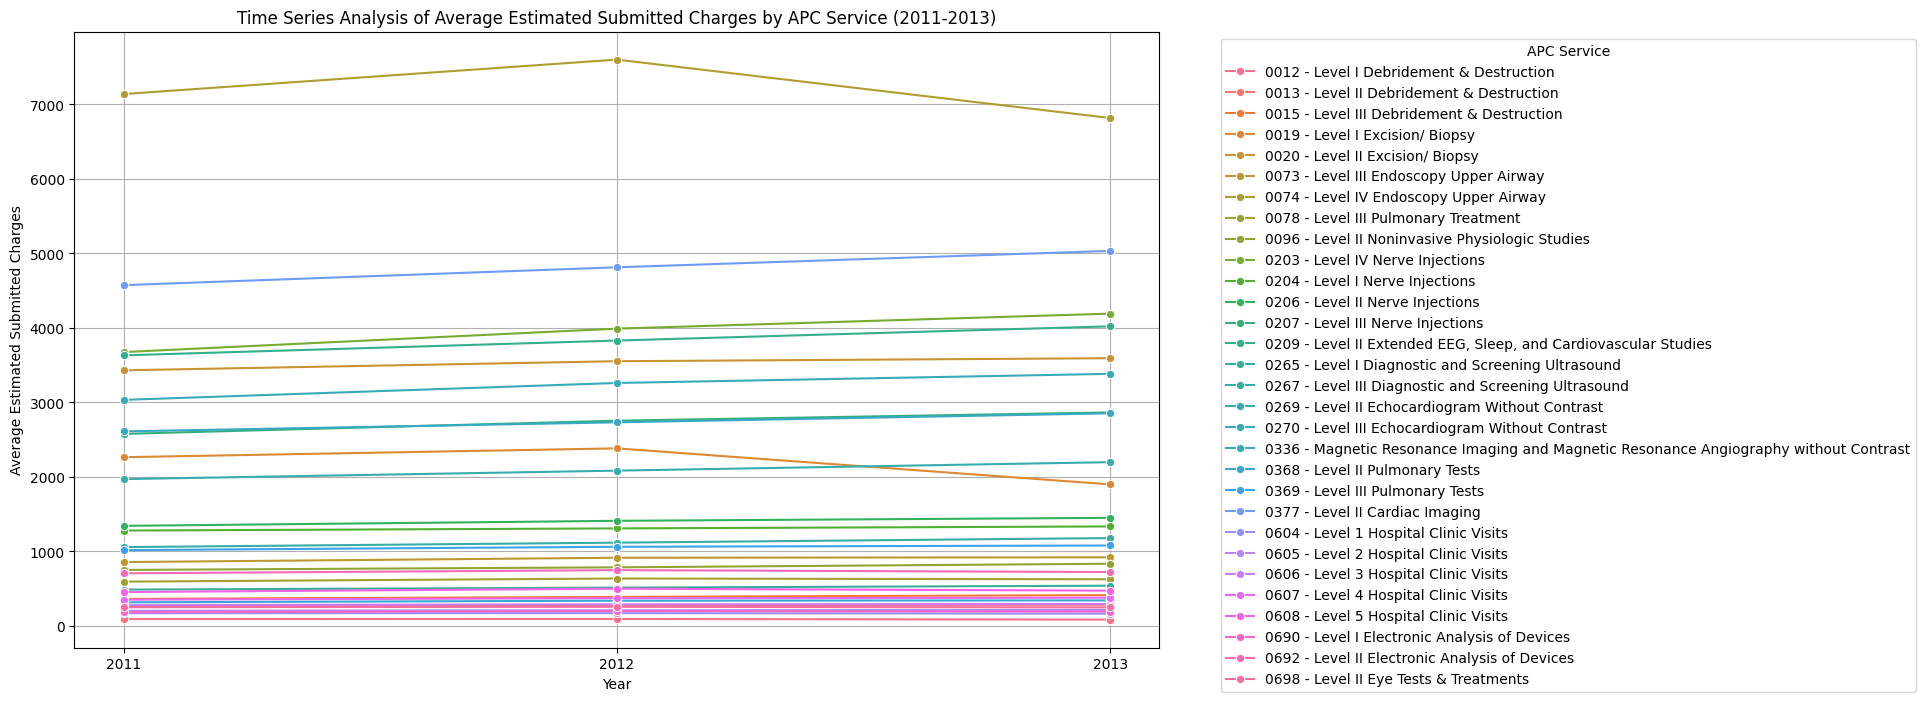

In [ ]:
import matplotlib.pyplot as plt

# Reset the index to make 'APC' a column, and then melt the DataFrame to have 'Year' and 'Average Charge' columns
apc_trends_melted = apc_trends.reset_index().melt(id_vars='apc', var_name='Year', value_name='Average Charge')

# Plotting the time series
plt.figure(figsize=(14, 8))
sns.lineplot(data=apc_trends_melted, x='Year', y='Average Charge', hue='apc', marker='o')

# Set plot labels and title
plt.title('Time Series Analysis of Average Estimated Submitted Charges by APC Service (2011-2013)')
plt.xlabel('Year')
plt.ylabel('Average Estimated Submitted Charges')
plt.legend(title='APC Service', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend outside
plt.grid(True)
plt.show()


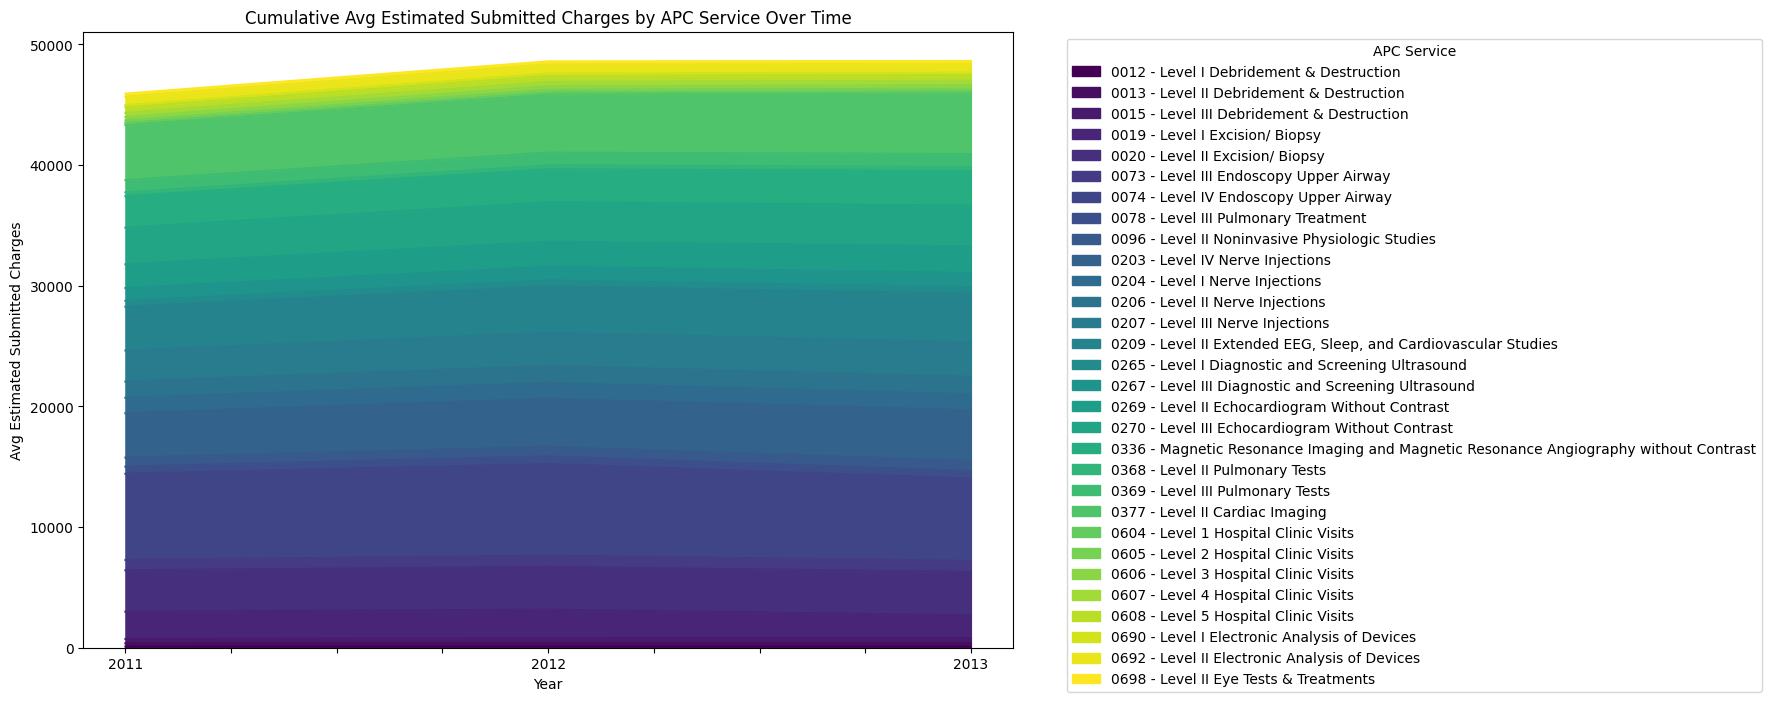

In [ ]:
apc_trends.T.plot(kind='area', stacked=True, figsize=(12, 8), colormap='viridis')
plt.xlabel('Year')
plt.ylabel('Avg Estimated Submitted Charges')
plt.title('Cumulative Avg Estimated Submitted Charges by APC Service Over Time')
plt.legend(title="APC Service", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## q3 .Geographical analysis by state on affordable providers that offer emergency charges.

In [ ]:
# Define an affordability threshold for all services based on the lower quartile
affordable_threshold = outpatient_data['average_total_payments'].quantile(0.25)
affordable_providers = outpatient_data[outpatient_data['average_total_payments'] <= affordable_threshold]


In [ ]:
# Aggregate by state to get the count and average cost of affordable services
affordable_by_state = affordable_providers.groupby('provider_state').agg(
    provider_count=('provider_id', 'nunique'),
    avg_cost=('average_total_payments', 'mean')
).reset_index()


In [ ]:
affordable_by_state.sample(5)

,provider_state,provider_count,avg_cost
25,MT,11,55.874332
26,NC,85,56.007369
10,GA,106,57.066044
3,AZ,46,61.464770
6,CT,30,62.132995


In [ ]:
import plotly.express as px

# Create a choropleth map
fig = px.choropleth(
    affordable_by_state,
    locations='provider_state',
    locationmode='USA-states',
    color='avg_cost',
    hover_name='provider_state',
    hover_data={'provider_count': True, 'avg_cost': True},
    scope='usa',
    title='Affordable Providers by State Based on Total Payments'
)

fig.show()


##Q4.Analyze the top 10 prominent inpatient ICD10 diagnosis based on state using their ICD10 Chapter and Block Descriptions

In [ ]:
import pandas as pd

# Initialize an empty list to store the structured data
icd_records = []

# Loop through each ICD-10 record in icd_data
for data in icd10_data.values():
    if isinstance(data, dict):  # Ensure 'data' is a dictionary
        # Safely extract values, using .get() to avoid errors if a key doesn't exist
        code = data.get('code', 'Unknown')
        title = data.get('title', {}).get('@value', 'Unknown')
        parent_list = data.get('parent', [])

        # Use the first item in the parent list as a substitute for Block
        chapter_block = parent_list[0] if parent_list else 'Unknown'

        # Add the extracted data to the list of records
        icd_records.append({
            'Code': code,
            'Title': title,
            'Chapter_Block': chapter_block,
            'Category': data.get('classKind', 'Unknown')
        })

# Convert the list of ICD records into a pandas DataFrame
df_icd = pd.DataFrame(icd_records)

# Display the DataFrame to check the extracted data
print(df_icd.head())

# Perform the analysis (e.g., grouping by Chapter_Block)
top_10_by_chapter_block = df_icd.groupby('Chapter_Block').size().nlargest(10)

# Output the results
print("\nTop 10 ICD-10 Diagnoses by Chapter_Block:")
print(top_10_by_chapter_block)


  Code                                              Title  \
0  G81                                         Hemiplegia   
1  T79  Certain early complications of trauma, not els...   
2  I02                                   Rheumatic chorea   
3  D18             Haemangioma and lymphangioma, any site   
4  P12                              Birth injury to scalp   

                                   Chapter_Block  Category  
0  http://id.who.int/icd/release/10/2019/G80-G83  category  
1  http://id.who.int/icd/release/10/2019/T79-T79  category  
2  http://id.who.int/icd/release/10/2019/I00-I02  category  
3  http://id.who.int/icd/release/10/2019/D10-D36  category  
4  http://id.who.int/icd/release/10/2019/P10-P15  category  

Top 10 ICD-10 Diagnoses by Chapter_Block:
Chapter_Block
http://id.who.int/icd/release/10/2019/D10-D36    24
http://id.who.int/icd/release/10/2019/I60-I69     8
http://id.who.int/icd/release/10/2019/F90-F98     7
http://id.who.int/icd/release/10/2019/R70-R79     7
ht

In [ ]:
# Extract just the block code from the 'Chapter_Block' URL
df_icd['Chapter_Block'] = df_icd['Chapter_Block'].apply(lambda x: x.split('/')[-1] if isinstance(x, str) else 'Unknown')

# Display the updated DataFrame to check the extracted block codes
print(df_icd.head())

top_10_by_chapter_block = df_icd.groupby('Chapter_Block').size().nlargest(10)

# Output the results
print("\nTop 10 ICD-10 Diagnoses by Chapter_Block:")
print(top_10_by_chapter_block)


  Code                                              Title Chapter_Block  \
0  G81                                         Hemiplegia       G80-G83   
1  T79  Certain early complications of trauma, not els...       T79-T79   
2  I02                                   Rheumatic chorea       I00-I02   
3  D18             Haemangioma and lymphangioma, any site       D10-D36   
4  P12                              Birth injury to scalp       P10-P15   

   Category  
0  category  
1  category  
2  category  
3  category  
4  category  

Top 10 ICD-10 Diagnoses by Chapter_Block:
Chapter_Block
D10-D36    24
I60-I69     8
F90-F98     7
R70-R79     7
A92-A99     6
J00-J06     6
P10-P15     6
B95-B98     4
D60-D64     4
F50-F59     4
dtype: int64


In [ ]:
df_icd.head()

,Code,Title,Chapter_Block,Category
0,G81,Hemiplegia,G80-G83,category
1,T79,"Certain early complications of trauma, not els...",T79-T79,category
2,I02,Rheumatic chorea,I00-I02,category
3,D18,"Haemangioma and lymphangioma, any site",D10-D36,category
4,P12,Birth injury to scalp,P10-P15,category


In [ ]:
# Merge df_icd with the inpatient_data on the ICD-10 code columns
df_icd_with_state = pd.merge(df_icd, inpatient_data[['icd_category', 'provider_state']],
                             left_on='Code', right_on='icd_category', how='left')

# Drop duplicate rows
df_icd_with_state.drop_duplicates(inplace=True)

# Drop the redundant 'icd_category' column after merge
df_icd_with_state.drop(columns=['icd_category'], inplace=True)

# Check the df
print("ICD-10 Data with State Information:")
print(df_icd_with_state.head())

ICD-10 Data with State Information:
   Code       Title Chapter_Block  Category provider_state
0   G81  Hemiplegia       G80-G83  category             TX
2   G81  Hemiplegia       G80-G83  category             NY
4   G81  Hemiplegia       G80-G83  category             OK
7   G81  Hemiplegia       G80-G83  category             ND
10  G81  Hemiplegia       G80-G83  category             ID


In [ ]:
inpatient_data.columns

Index(['provider_id', 'provider_name', 'provider_street_address',
       'provider_city', 'provider_state', 'provider_zipcode',
       'hospital_referral_region_description', 'total_discharges',
       'average_covered_charges', 'average_total_payments',
       'average_medicare_payments', 'icd_category', 'year'],
      dtype='object')

In [ ]:
df_icd_with_state.sample(10)

,Code,Title,Chapter_Block,Category,provider_state
15327,J05,Acute obstructive laryngitis [croup] and epigl...,J00-J06,category,NV
3144,D31,Benign neoplasm of eye and adnexa,D10-D36,category,ID
1103,D18,"Haemangioma and lymphangioma, any site",D10-D36,category,ND
12619,D16,Benign neoplasm of bone and articular cartilage,D10-D36,category,GA
25905,D14,Benign neoplasm of middle ear and respiratory ...,D10-D36,category,OH
28116,J04,Acute laryngitis and tracheitis,J00-J06,category,OH
23326,D30,Benign neoplasm of urinary organs,D10-D36,category,PA
25352,D35,Benign neoplasm of other and unspecified endoc...,D10-D36,category,GA
23366,D30,Benign neoplasm of urinary organs,D10-D36,category,CA
8796,I69,Sequelae of cerebrovascular disease,I60-I69,category,CA


In [ ]:
# Count frequency of ICD-10 diagnoses by state
inpatient_diagnoses_counts = inpatient_data.groupby(['provider_state', 'icd_category']).size().reset_index(name='count')

# Merge with ICD-10 data for chapter and block descriptions
top_diagnoses = inpatient_diagnoses_counts.merge(df_icd, left_on='icd_category', right_on='Code')

# Rank and select top 10 diagnoses per state
top_diagnoses['Rank'] = top_diagnoses.groupby('provider_state')['count'].rank(ascending=False)
top_10_diagnoses_per_state = top_diagnoses[top_diagnoses['Rank'] <= 10]


In [ ]:
top_10_diagnoses_per_state.sample(10)

,provider_state,icd_category,count,Code,Title,Chapter_Block,Category,Rank
82,AZ,J06,24,J06,Acute upper respiratory infections of multiple...,J00-J06,category,8.0
1408,OK,D31,68,D31,Benign neoplasm of eye and adnexa,D10-D36,category,3.0
1211,NY,D18,30,D18,"Haemangioma and lymphangioma, any site",D10-D36,category,4.5
29,AZ,D18,26,D18,"Haemangioma and lymphangioma, any site",D10-D36,category,1.5
3,AL,D28,3,D28,Benign neoplasm of other and unspecified femal...,D10-D36,category,4.5
1362,OH,P11,18,P11,Other birth injuries to central nervous system,P10-P15,category,10.0
1678,TX,D22,42,D22,Melanocytic naevi,D10-D36,category,6.0
1305,OH,D18,18,D18,"Haemangioma and lymphangioma, any site",D10-D36,category,10.0
693,IN,I01,18,I01,Rheumatic fever with heart involvement,I00-I02,category,9.5
215,FL,D18,116,D18,"Haemangioma and lymphangioma, any site",D10-D36,category,3.5


In [ ]:
icd_counts = inpatient_data.groupby(['provider_state', 'icd_category']).size().reset_index(name='count')
top_icd_by_state = icd_counts.groupby('provider_state').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)


<ipython-input-60-ed069b72f8cb>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [ ]:
top_icd_by_state.head(10)

,provider_state,icd_category,count
0,AL,D18,3
1,AL,D28,3
2,AL,D31,3
3,AL,I01,3
4,AL,I02,3
5,AL,J01,3
6,AL,J02,3
7,AL,R82,3
8,AL,D22,2
9,AL,Y07,2


In [ ]:
df_icd_with_state.provider_state.value_counts()

,count
provider_state,
TX,94
NE,94
FL,94
NV,94
NY,94
GA,94
MI,94
PA,94
IN,94


In [ ]:
df_icd_with_state.provider_state.nunique()

22

<ipython-input-23-8548d3987649>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(10, 'count')) \
<ipython-input-23-8548d3987649>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='Code', data=state_data, palette='viridis')


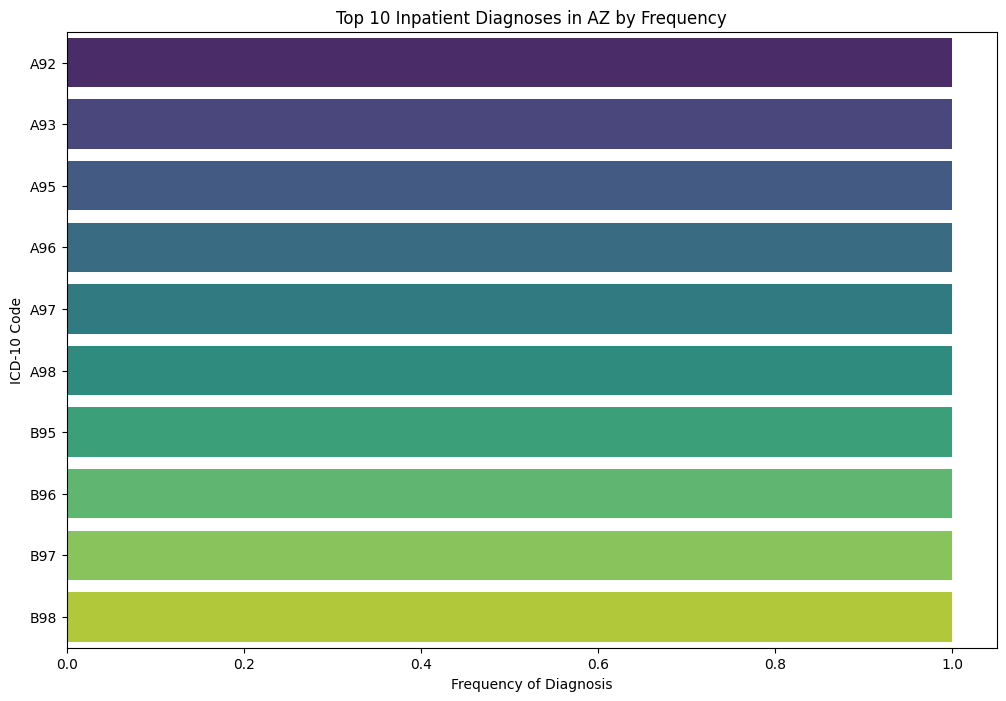

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by state and ICD-10 code (icd_category), then count occurrences of each code in each state
state_diagnosis_counts = df_icd_with_state.groupby(['provider_state', 'Code']).size().reset_index(name='count')

# For each state, sort by count and get the top 10 diagnoses
top_10_diagnoses_per_state = state_diagnosis_counts.groupby('provider_state') \
    .apply(lambda x: x.nlargest(10, 'count')) \
    .reset_index(drop=True)

# Merge with ICD-10 chapter/block descriptions
top_10_diagnoses_per_state = top_10_diagnoses_per_state.merge(df_icd_with_state[['Code', 'Chapter_Block']], on='Code', how='left')

# Visualize the results for one state
state_to_visualize = 'AZ'
state_data = top_10_diagnoses_per_state[top_10_diagnoses_per_state['provider_state'] == state_to_visualize]

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='Code', data=state_data, palette='viridis')
plt.title(f"Top 10 Inpatient Diagnoses in {state_to_visualize} by Frequency")
plt.xlabel('Frequency of Diagnosis')
plt.ylabel('ICD-10 Code')
plt.show()


In [ ]:
#saving all the data set I will need for Visualization in Tableau
inpatient_data.to_csv('inpatient_data.csv', index=False)
outpatient_data.to_csv('outpatient_data.csv', index=False)
df_icd_with_state.to_csv('df_icd_with_state.csv', index=False)
top_10_diagnoses_per_state.to_csv('/top_10_diagnoses_per_state.csv', index=False)
affordable_by_state.to_csv('affordable_by_state.csv', index=False)
outpatient_avg_payments.to_csv('outpatient_avg_payments.csv', index=False)
inpatient_avg_payments.to_csv('inpatient_avg_payments.csv', index=False)
apc_trends.to_csv('apc_trends.csv', index=False)